/var/folders/9z/lnzs0dyx0k1g2nvs92hf0syr0000gn/T/ipykernel_3834/1518155942.py:24: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_election = pd.read_sql(query_election, conn)
/var/folders/9z/lnzs0dyx0k1g2nvs92hf0syr0000gn/T/ipykernel_3834/1518155942.py:31: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_economie = pd.read_sql(query_economie, conn)


cluster  winner                   
0        Rassemblement National       4757
         La République En Marche      2242
         La France Insoumise           908
         Résistons                      98
         Reconquête                     17
         Les Républicains               10
         Parti Communiste Français       7
         Europe Écologie Les Verts       5
         Lutte Ouvrière                  4
         Parti Socialiste                2
1        La République En Marche      1310
         Rassemblement National       1256
         La France Insoumise           288
         Résistons                      18
         Les Républicains                5
         Parti Communiste Français       3
2        Rassemblement National       4268
         La République En Marche      1049
         La France Insoumise           404
         Résistons                      11
         Reconquête                      8
         Lutte Ouvrière                  3
         Parti Comm

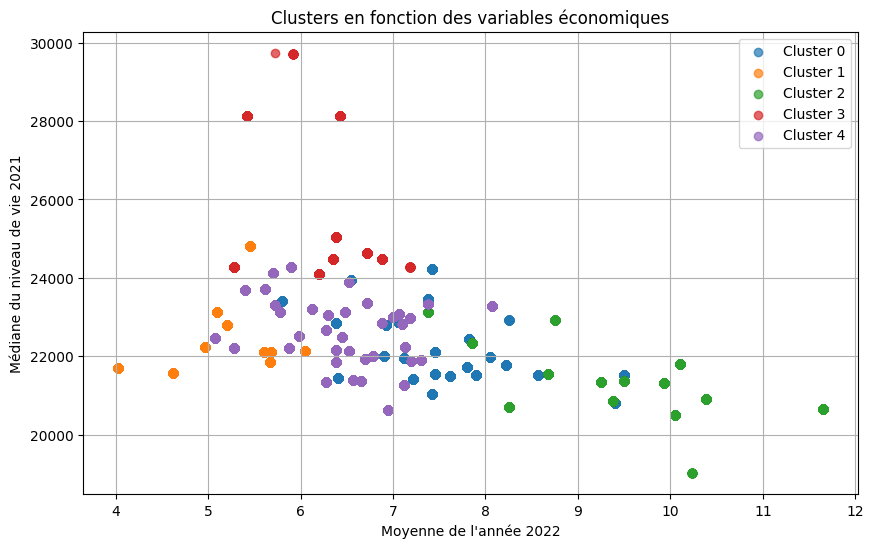

In [10]:
from matplotlib import pyplot as plt
import psycopg2
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Paramètres de connexion à la base de données PostgreSQL
conn_params = {
    "host": "localhost",
    "port": "15432", 
    "database": "postgres",
    "user": "admin",
    "password": "admin"
}

# Connexion à la base de données
conn = psycopg2.connect(**conn_params)

# Requête SQL pour récupérer les données des élections
query_election = """
    SELECT winner, code_postal
    FROM election_2022_t1
"""
df_election = pd.read_sql(query_election, conn)

# Requête SQL pour récupérer les données économiques
query_economie = """
    SELECT *
    FROM economie
"""
df_economie = pd.read_sql(query_economie, conn)

# Fermeture de la connexion à la base de données
conn.close()

# Combinaison des données des élections et économiques en fonction du code postal
df_combined = pd.merge(df_election, df_economie, on="code_postal", how="inner")

# Sélection des colonnes à utiliser pour le clustering
X = df_combined.drop(columns=["winner", "code_postal"])

# Standardisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Entraînement du modèle de clustering K-means
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X_scaled)

# Ajout des clusters prédits au DataFrame combiné
df_combined["cluster"] = kmeans.labels_

# Analyse des clusters
cluster_summary = df_combined.groupby("cluster")["winner"].value_counts()

# Affichage du résultat de l'analyse
print(cluster_summary)

# Visualisation des clusters en fonction des variables économiques (par exemple, "avg_2022" et "Médiane du niveau de vie 2021")
plt.figure(figsize=(10, 6))
for cluster in range(5):
    cluster_data = df_combined[df_combined["cluster"] == cluster]
    plt.scatter(cluster_data["avg_2022"], cluster_data["Médiane du niveau de vie 2021"], label=f"Cluster {cluster}", alpha=0.7)

plt.xlabel("Moyenne de l'année 2022")
plt.ylabel("Médiane du niveau de vie 2021")
plt.title("Clusters en fonction des variables économiques")
plt.legend()
plt.grid(True)
plt.show()